###**Import Library dan Load Dataset**

In [7]:
# Install library
!pip install openpyxl scikit-learn kmodes

# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from kmodes.kmodes import KModes

# Load dataset
url = 'https://github.com/farrelrassya/teachingMLDL/raw/main/01.%20Machine%20Learning/06.%20Week%206/Datasets/Online%20Retail.xlsx'
df = pd.read_excel(url)

###**Preprocessing Data**

In [8]:
# Drop null dan data yang tidak lengkap
df.dropna(subset=['CustomerID'], inplace=True)

# Menggunakan fitur numerik: jumlah transaksi per customer
data_customer = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Country': 'first'
}).reset_index()

# Rename
data_customer.columns = ['CustomerID', 'TotalInvoices', 'TotalQuantity', 'AvgPrice', 'Country']

# Feature selection
features = data_customer[['TotalInvoices', 'TotalQuantity', 'AvgPrice']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

###**Model Clustering KMeans**

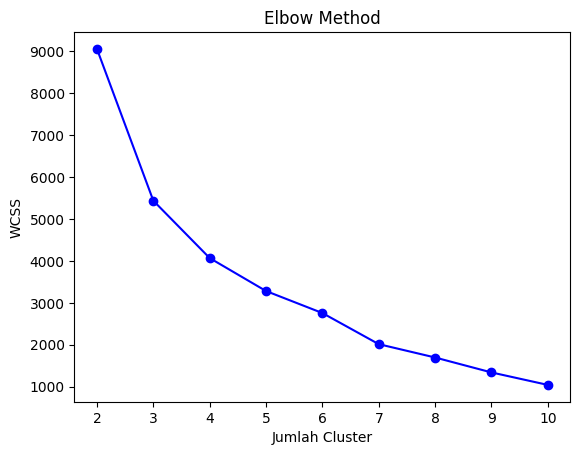

In [11]:
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 11), wcss, 'bo-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

###**Model Clustering DBSCAN**

In [12]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

###**Evaluasi Model**


In [14]:
# KMeans dengan k optimal (misal 4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Silhouette Coefficient
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
sil_dbscan = silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Calinski-Harabasz Index
ch_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
ch_dbscan = calinski_harabasz_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Davies-Bouldin Index
db_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)
db_dbscan = davies_bouldin_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Hasil
print(f"Silhouette Score - KMeans  : {sil_kmeans:.3f}, DBSCAN: {sil_dbscan:.3f}")
print(f"Calinski-Harabasz - KMeans : {ch_kmeans:.3f}, DBSCAN: {ch_dbscan:.3f}")
print(f"Davies-Bouldin - KMeans    : {db_kmeans:.3f}, DBSCAN: {db_dbscan:.3f}")

Silhouette Score - KMeans  : 0.792, DBSCAN: 0.951
Calinski-Harabasz - KMeans : 3239.027, DBSCAN: 1702.455
Davies-Bouldin - KMeans    : 0.640, DBSCAN: 1.086


##**Penjelasan Matematis**

### 1. Silhouette Coefficient (SC)

**Silhouette Coefficient** mengukur seberapa mirip suatu objek dengan *cluster*-nya sendiri dibandingkan dengan *cluster* lainnya. Nilai metrik ini berkisar dari -1 hingga 1.

$$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$

Di mana:
* $a(i)$: Rata-rata jarak antara titik $i$ dan semua titik lain dalam *cluster*-nya sendiri. Ini menunjukkan seberapa padat *cluster* internalnya.
* $b(i)$: Rata-rata jarak minimum antara titik $i$ dan semua *cluster* lain (yaitu, jarak ke *cluster* tetangga terdekat). Ini menunjukkan seberapa jauh titik tersebut dari *cluster* lain.

**Interpretasi**: Nilai SC yang mendekati **1** menunjukkan pemisahan *cluster* yang sangat baik, di mana titik-titik data berada pada *cluster* yang sesuai dan jauh dari *cluster* lainnya. Nilai mendekati 0 berarti titik berada di perbatasan *cluster*, dan nilai negatif berarti titik mungkin salah dikelompokkan.

### 2. Calinski-Harabasz Index (CH)

**Calinski-Harabasz Index** mengukur rasio antara variansi antar-*cluster* (*between-cluster dispersion*) dan variansi di dalam *cluster* (*within-cluster dispersion*). Secara intuitif, kita menginginkan *cluster* yang terpisah jauh satu sama lain, tetapi padat di dalamnya.

$$CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}$$

Di mana:
* $\text{Tr}(B_k)$: *Trace* dari *between-cluster dispersion matrix*, merepresentasikan seberapa jauh *centroid* *cluster* satu sama lain.
* $\text{Tr}(W_k)$: *Trace* dari *within-cluster dispersion matrix*, merepresentasikan seberapa padat titik-titik di dalam setiap *cluster*.
* $n$: Jumlah total titik data.
* $k$: Jumlah *cluster*.

**Interpretasi**: Semakin **tinggi** nilai Calinski-Harabasz Index, semakin baik pemisahan dan kepadatan *cluster*.

### 3. Davies-Bouldin Index (DBI)

**Davies-Bouldin Index** mengevaluasi kualitas *clustering* dengan mengukur rata-rata "kesamaan" antara setiap *cluster* dan *cluster* yang paling mirip dengannya. Kesamaan ini dihitung sebagai rasio antara dispersi di dalam *cluster* dan jarak antar-*cluster*.

$$DBI = \frac{1}{k} \sum_{i=1}^{k} \max_{j \ne i} \left( \frac{s_i + s_j}{d_{ij}} \right)$$

Di mana:
* $s_i$: Rata-rata jarak setiap titik ke pusat *cluster*-nya, yang menunjukkan ukuran atau kepadatan *cluster* $i$.
* $d_{ij}$: Jarak antar pusat *cluster* $i$ dan $j$.

**Interpretasi**: Semakin **rendah** nilai Davies-Bouldin Index, semakin baik *clustering*-nya. Ini mengindikasikan *cluster* yang lebih padat secara internal dan lebih terpisah satu sama lain.

### 4. Dunn Index (Opsional)

**Dunn Index** adalah metrik yang bertujuan untuk mengidentifikasi *cluster* yang kompak dan terpisah dengan baik. Ini dihitung sebagai rasio antara jarak minimum antar *cluster* dengan diameter maksimum *cluster*.

$$D_{unn} = \frac{\min_{c_i \ne c_j} d(c_i, c_j)}{\max_k d(C_k)}$$

Di mana:
* $d(c_i, c_j)$: Jarak minimum antara dua titik yang berada di *cluster* yang berbeda ($c_i$ dan $c_j$).
* $d(C_k)$: Diameter maksimum *cluster* $k$, yaitu jarak terbesar antara dua titik di dalam *cluster* tersebut.

**Interpretasi**: Semakin **tinggi** nilai Dunn Index, semakin baik *clustering*-nya. Ini idealnya menunjukkan *cluster* yang padat (diameter kecil) dan terpisah jauh satu sama lain (jarak antar-*cluster* besar).
